In [29]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import math
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import mediapipe as mp
from sklearn.metrics import confusion_matrix
import pickle
import pathlib
import warnings
warnings.filterwarnings("ignore")

In [30]:
# ==== Dataset Paths ====
train_path = pathlib.Path('/Users/bhavya/codes/jupyter/Yoga/yoga-16/56-8-16/train')
val_path = pathlib.Path('/Users/bhavya/codes/jupyter/Yoga/yoga-16/56-8-16/valid')
test_path = pathlib.Path('/Users/bhavya/codes/jupyter/Yoga/yoga-16/56-8-16/test')
image_classes = sorted(os.listdir(train_path))


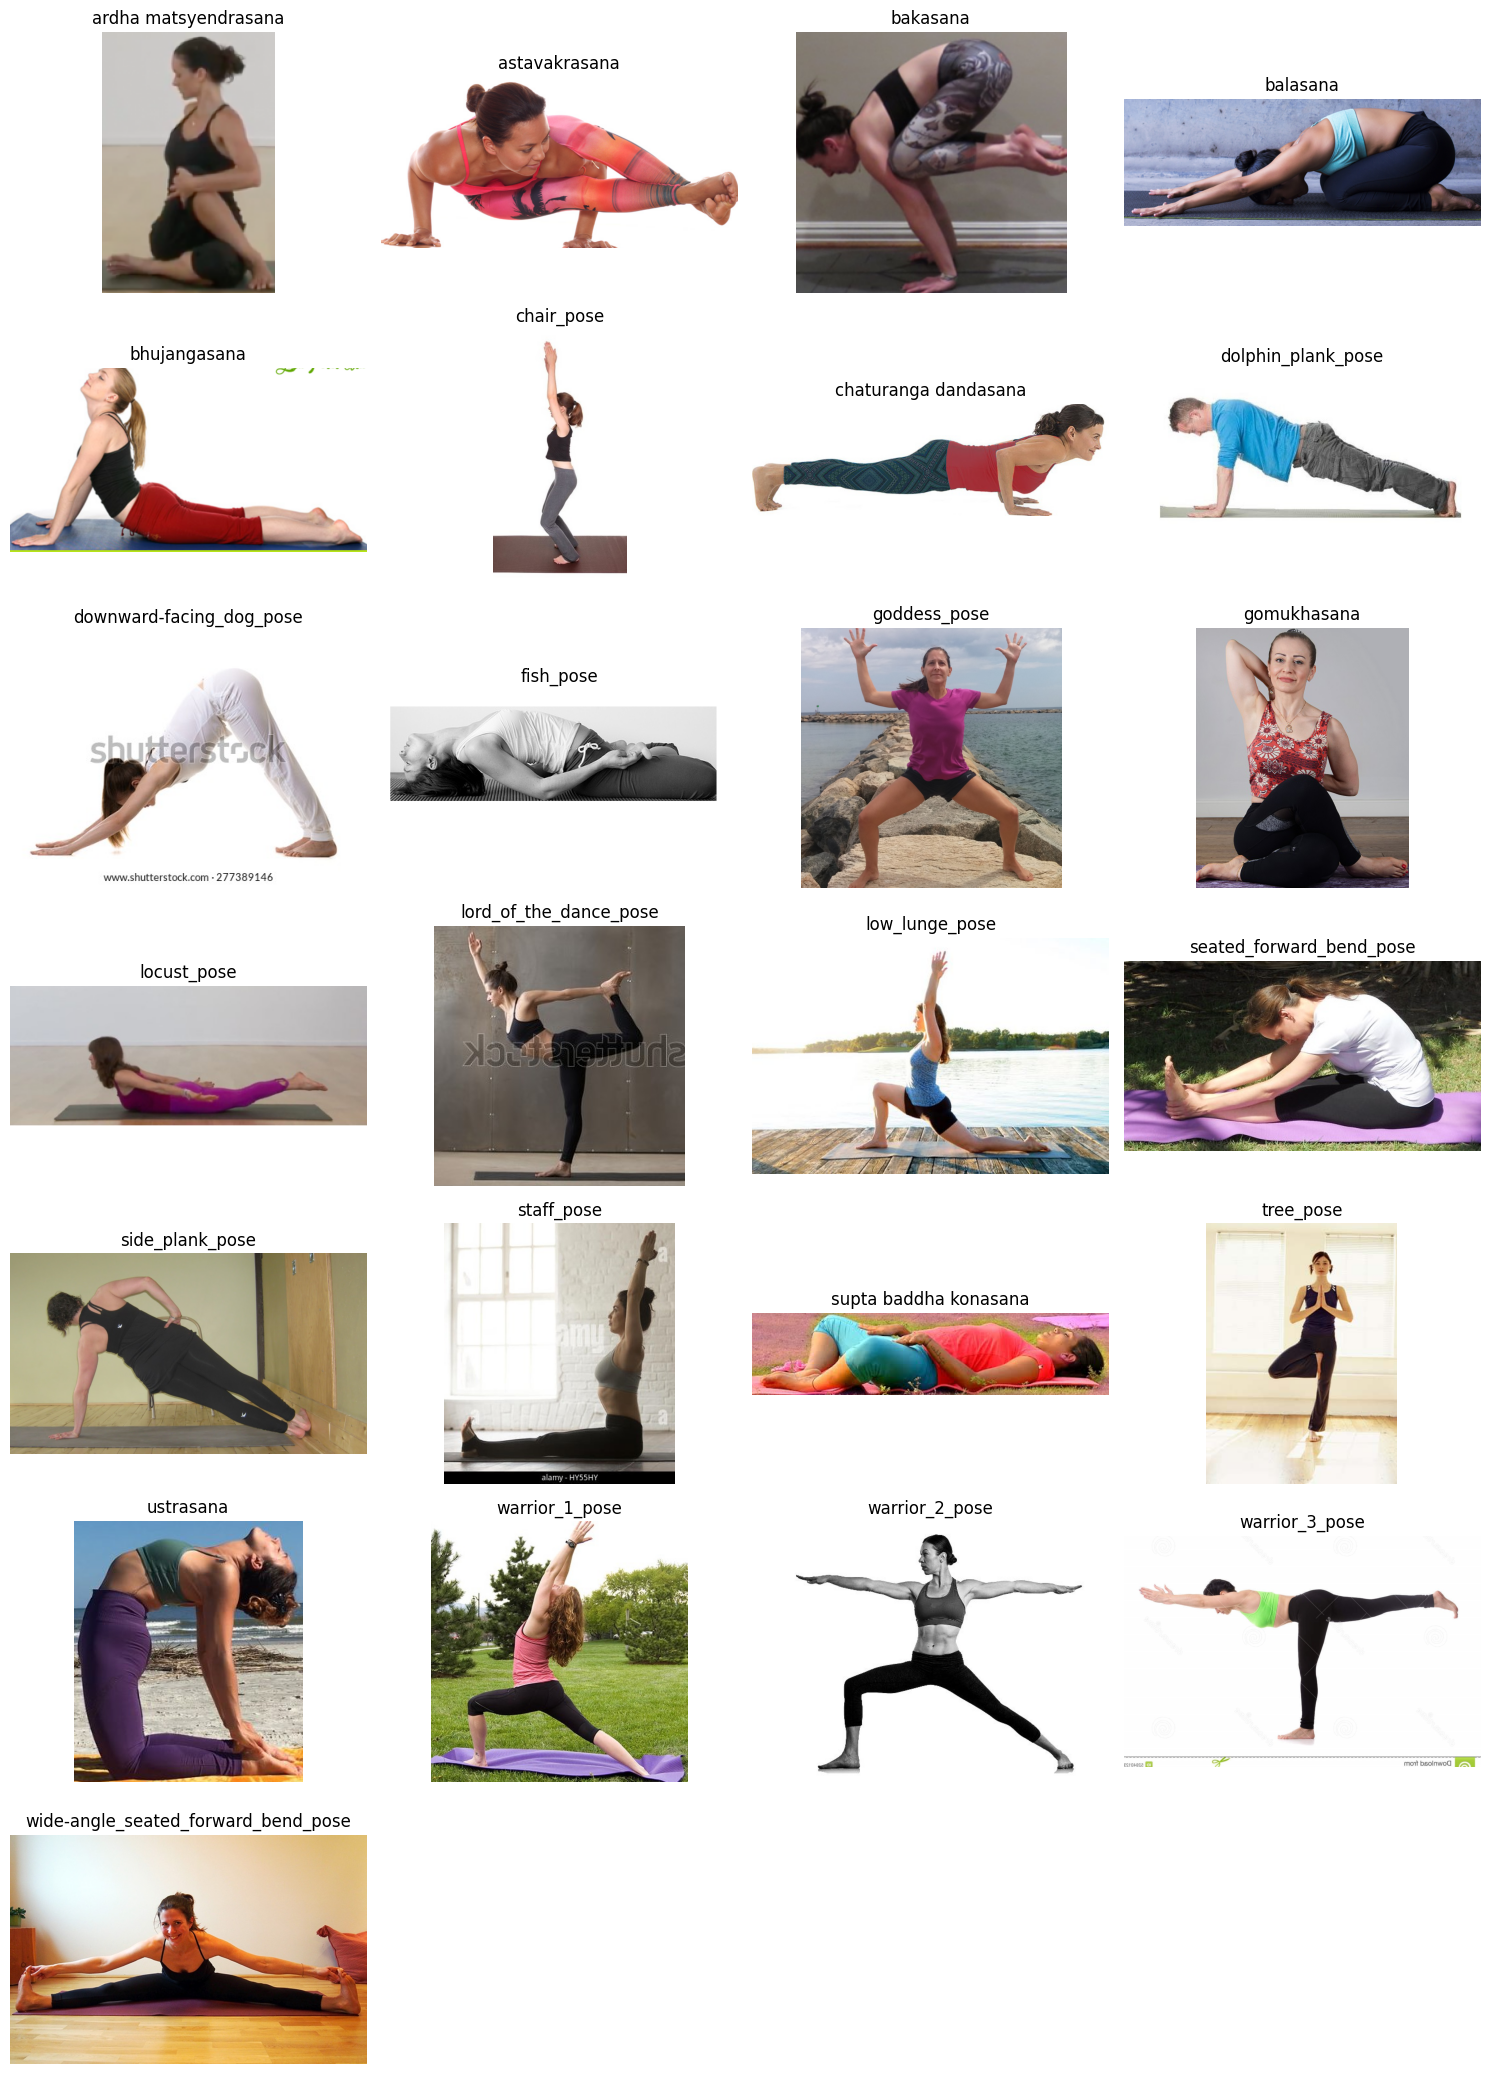

In [31]:
# ==== Image Visualization ====
def plot_images(image_classes):
    total = len(image_classes)
    cols = 4
    rows = math.ceil(total / cols)
    plt.figure(figsize=(15, rows * 3))
    idx = 1
    for category in image_classes:
        image_path = train_path / category
        if not image_path.is_dir():
            continue
        image_in_folder = os.listdir(image_path)
        if not image_in_folder:
            continue
        first_image = image_in_folder[0]
        first_image_path = image_path / first_image
        try:
            img_array = imageio.imread(first_image_path)
            plt.subplot(rows, cols, idx)
            plt.imshow(img_array)
            plt.title(category)
            plt.axis('off')
            idx += 1
        except Exception as e:
            print(f"Skipping {first_image_path}: {e}")
            continue
    plt.tight_layout()
    plt.show()

plot_images(image_classes)

In [32]:
# ==== Keypoint Extraction ====
from pathlib import Path
from PIL import Image, UnidentifiedImageError

def extract_keypoints_from_image(img_path):
    try:
        img = Image.open(img_path).convert('RGB').resize((256, 256))
    except UnidentifiedImageError:
        print(f"Skipping file (not an image): {img_path}")
        return None
    
    results = pose.process(np.array(img))
    if results.pose_landmarks:
        return [(lm.x, lm.y, lm.z) for lm in results.pose_landmarks.landmark]
    return None

def create_dataset_from_directory(directory):
    directory = Path(directory)
    data = []
    for label in os.listdir(directory):
        label_path = directory / label
        if not label_path.is_dir():
            continue
        for img_file in os.listdir(label_path):
            if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                continue
            img_path = label_path / img_file
            keypoints = extract_keypoints_from_image(img_path)
            if keypoints:
                data.append({'keypoints': keypoints, 'label': label})
    return data


train_data = create_dataset_from_directory(train_path)
valid_data = create_dataset_from_directory(val_path)
test_data  = create_dataset_from_directory(test_path)


In [33]:
# ==== Preprocessing ====
def get_center_point(landmarks, left_idx, right_idx):
    left = landmarks[left_idx][:2]
    right = landmarks[right_idx][:2]
    return (np.array(left) + np.array(right)) * 0.5

def get_pose_size(landmarks, torso_size_multiplier=2.5):
    hips_center = get_center_point(landmarks, 23, 24)
    shoulders_center = get_center_point(landmarks, 11, 12)
    torso_size = np.linalg.norm(shoulders_center - hips_center)
    pose_center = hips_center
    dists = np.linalg.norm(np.array(landmarks)[:, :2] - pose_center, axis=1)
    max_dist = np.max(dists)
    return max(torso_size * torso_size_multiplier, max_dist)

def normalize_pose_landmarks(landmarks):
    pose_center = get_center_point(landmarks, 23, 24)
    landmarks = np.array(landmarks)
    landmarks[:, :2] -= pose_center
    pose_size = get_pose_size(landmarks)
    landmarks /= pose_size
    return landmarks[:, :2].flatten()

def preprocess_dataset(data):
    embeddings, labels = [], []
    for d in data:
        embedding = normalize_pose_landmarks(d['keypoints'])
        embeddings.append(embedding)
        labels.append(d['label'])
    return np.array(embeddings), np.array(labels)

X_train, y_train = preprocess_dataset(train_data)
X_valid, y_valid = preprocess_dataset(valid_data)
X_test, y_test = preprocess_dataset(test_data)

In [34]:
print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(valid_data)}")
print(f"Test samples: {len(test_data)}")

Train samples: 1320
Validation samples: 192
Test samples: 385


In [35]:
# Extract unique labels
unique_labels = sorted(set(item['label'] for item in train_data))

# Create label mappings
label_to_int = {label: idx for idx, label in enumerate(unique_labels)}
int_to_label = {idx: label for label, idx in label_to_int.items()}

In [36]:
# Save the label_to_int dictionary as a pickle file
with open('label_to_int.pkl', 'wb') as f:
    pickle.dump(label_to_int, f)

def convert_labels(y):
    return np.array([label_to_int[label] for label in y])

y_train_int = keras.utils.to_categorical(convert_labels(y_train))
y_valid_int = keras.utils.to_categorical(convert_labels(y_valid))
y_test_int = keras.utils.to_categorical(convert_labels(y_test))

In [37]:
# ==== Reshape for CNN ====
def reshape_for_cnn(X):
    return X.reshape(-1, 11, 6, 1)  # 66 = 33 keypoints * 2 (x, y)

X_train_cnn = reshape_for_cnn(X_train)
X_valid_cnn = reshape_for_cnn(X_valid)
X_test_cnn = reshape_for_cnn(X_test)

In [38]:
# ==== CNN Model ====
def conv_block(x, filters, kernel_size, strides=(1, 1), reg=0.001):
    x = Conv2D(filters, kernel_size, padding='same', strides=strides, kernel_regularizer=l2(reg))(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

def build_advanced_cnn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = conv_block(inputs, 32, (3, 3))
    x = conv_block(x, 32, (3, 3))
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)

    x = conv_block(x, 64, (3, 3))
    x = conv_block(x, 64, (3, 3))
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.4)(x)

    x = conv_block(x, 128, (3, 3))
    x = conv_block(x, 128, (3, 3))
    x = GlobalAveragePooling2D()(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(0.5)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

model = build_advanced_cnn((11, 6, 1), len(unique_labels))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 11, 6, 1)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 11, 6, 32)      │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 11, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 11, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 11, 6, 32)      │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 11, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 11, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 5, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 5, 3, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 5, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 5, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 5, 3, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 5, 3, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 5, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 2, 1, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 2, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 2, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 2, 1, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 2, 1, 128)      │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 307,961 (1.17 MB)

 Trainable params: 307,065 (1.17 MB)

 Non-trainable params: 896 (3.50 KB)

In [39]:
# ==== Training ====
checkpoint = ModelCheckpoint("best_pose_model.keras", monitor="val_accuracy", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5)
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(X_train_cnn, y_train_int,
                    epochs=200,
                    batch_size=32,
                    validation_data=(X_valid_cnn, y_valid_int),
                    callbacks=[checkpoint, reduce_lr, early_stop])


Epoch 1/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 99ms/step - accuracy: 0.0675 - loss: 3.8242 - val_accuracy: 0.0417 - val_loss: 3.5621 - learning_rate: 0.0010
Epoch 2/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.1855 - loss: 2.9772 - val_accuracy: 0.0417 - val_loss: 3.5972 - learning_rate: 0.0010
Epoch 3/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3108 - loss: 2.5063 - val_accuracy: 0.0417 - val_loss: 3.7327 - learning_rate: 0.0010
Epoch 4/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.3895 - loss: 2.2333 - val_accuracy: 0.0417 - val_loss: 3.9373 - learning_rate: 0.0010
Epoch 5/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.4485 - loss: 2.0584 - val_accuracy: 0.0365 - val_loss: 4.2224 - learning_rate: 0.0010
Epoch 6/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.5145 - loss: 1.8834 - val_accuracy: 0.0365 - val_loss: 4.4146 - learning_rate: 0.0010
Epoch 7/200
42/42 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5612 - loss: 1.7722 - 

In [40]:
# ==== Evaluation ====
loss, accuracy = model.evaluate(X_test_cnn, y_test_int)
print("Test LOSS:", loss)
print("Test ACCURACY:", accuracy)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8927 - loss: 0.6598 
Test LOSS: 0.7098531126976013
Test ACCURACY: 0.8987013101577759


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step 


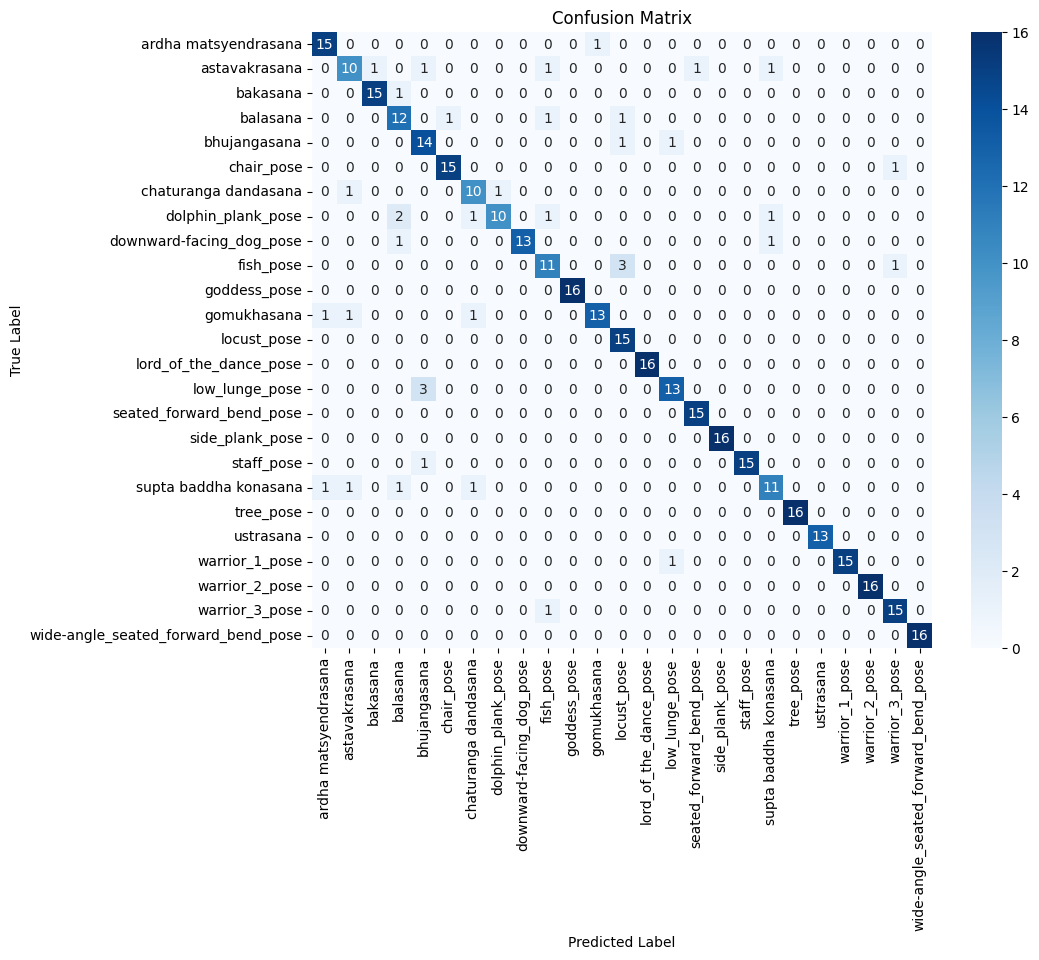

In [41]:
# ==== Confusion Matrix ====
y_pred = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_int, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

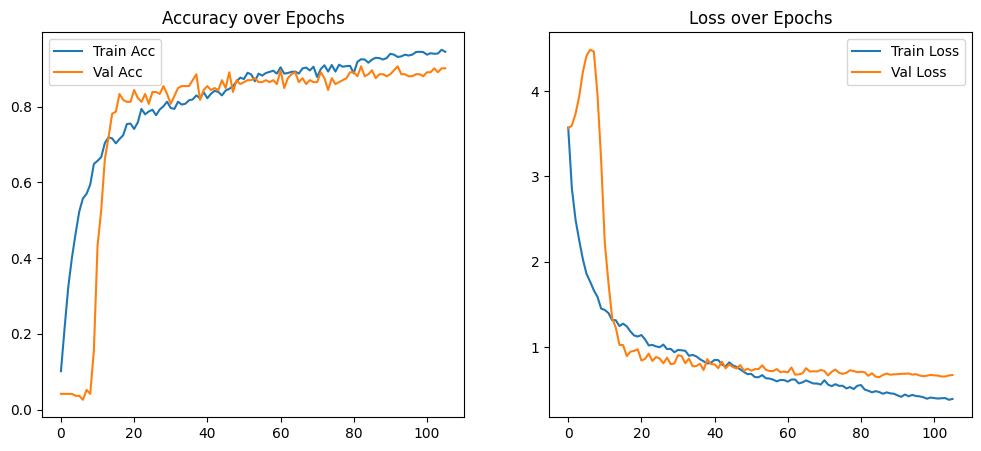

In [42]:
# ==== Training Graphs ====
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy over Epochs")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss over Epochs")
plt.legend()
plt.show()

In [43]:
# Save final model
final_model_path = "30_poses_CNN_90_acc.keras"
model.save(final_model_path)

In [44]:
# Predict classes for test data
y_pred = model.predict(X_test_cnn)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test_int, axis=1)

# Generate classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=unique_labels)
print("Classification Report:\n")
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Classification Report:

                                     precision    recall  f1-score   support

               ardha matsyendrasana       0.88      0.94      0.91        16
                      astavakrasana       0.77      0.67      0.71        15
                           bakasana       0.94      0.94      0.94        16
                           balasana       0.71      0.80      0.75        15
                       bhujangasana       0.74      0.88      0.80        16
                         chair_pose       0.94      0.94      0.94        16
               chaturanga dandasana       0.77      0.83      0.80        12
                 dolphin_plank_pose       0.91      0.67      0.77        15
           downward-facing_dog_pose       1.00      0.87      0.93        15
                          fish_pose       0.73      0.73      0.73        15
                       goddess_pose       1.00      1.00      1.00        16
           